#Deep Learning-Based Approach for Accurate and Efficient Brain Tumor Detection Using Convolutional Neural Networks

In [ ]:
pip install pydicom

  Using cached pydicom-2.4.4-py3-none-any.whl.metadata (7.8 kB)
Using cached pydicom-2.4.4-py3-none-any.whl (1.8 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [ ]:
## Importing the libraries ##
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import imutils

In [ ]:
import json
import glob
import random
import collections
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


Importing data

In [ ]:
### Import trainig data ###
train_dir = '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training'
glioma_dir = os.path.join(train_dir, 'glioma')
meningioma_dir = os.path.join(train_dir, 'meningioma')
pituitary_dir = os.path.join(train_dir, 'pituitary')
notumor_dir = os.path.join(train_dir, 'notumor')

In [ ]:
### Import TESTING data ### ##Change this
test_dir = '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Testing'
glioma_test_dir = os.path.join(test_dir, 'glioma')
meningioma_test_dir = os.path.join(test_dir, 'meningioma')
pituitary_test_dir = os.path.join(test_dir, 'pituitary')
notumor_test_dir = os.path.join(test_dir, 'notumor')

Data Preporcessing

Load images from the given training and testing directories, resize them, and prepare them for model training/testing.

Args:
   
train_dir (str): Path to the directory containing the training subdirectories.
   
test_dir (str): Path to the directory containing the testing subdirectories.
    
img_size (tuple): Desired size for the images (width, height). Default is (128, 128).
    
Returns:

X_train, y_train: Numpy arrays containing the training data and labels.

X_test, y_test: Numpy arrays containing the testing data and labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data(train_dir, test_dir, img_size=(128, 128)):
    """
    Load images from the given training and testing directories, resize them, and prepare them for model training/testing.
    """
    categories = ['glioma', 'meningioma', 'pituitary', 'notumor']

    def load_images_from_directory(directory, img_size):
        image_data = []
        labels = []
        for category in categories:
            category_dir = os.path.join(directory, category)
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize the image
                    img = cv2.resize(img, img_size)
                    # Normalize the image
                    img = img / 255.0
                    # Append to data lists
                    image_data.append(img)
                    labels.append(category)
        return np.array(image_data), np.array(labels)

    # Load training data
    X_train, y_train = load_images_from_directory(train_dir, img_size)

    # Load testing data
    X_test, y_test = load_images_from_directory(test_dir, img_size)

    # Encode labels using LabelEncoder fitted on the training labels
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)

    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Convert to categorical (one-hot encoding)
    y_train = to_categorical(y_train_encoded, num_classes=len(categories))
    y_test = to_categorical(y_test_encoded, num_classes=len(categories))

    return X_train, y_train, X_test, y_test

# Example usage:
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_dir, test_dir, img_size=(128, 128))

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (5771, 128, 128, 3)
Testing data shape: (1321, 128, 128, 3)
Training labels shape: (5771, 4)
Testing labels shape: (1321, 4)


EDA

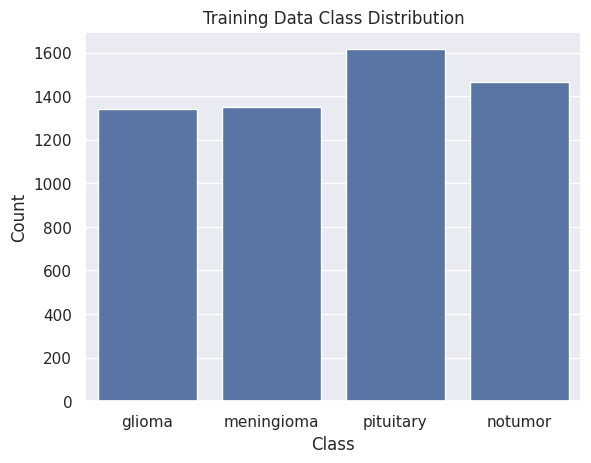

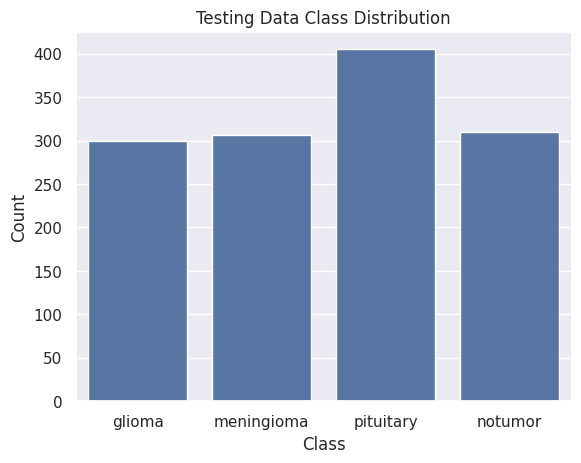

In [ ]:
# 1. Visualize Class Distribution in the Training Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize Class Distribution in the Training Data
def plot_class_distribution(y, title='Class Distribution'):
    sns.set(style="darkgrid")

    # Calculate the class counts
    class_counts = np.sum(y, axis=0)
    class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

    # Plot the distribution
    sns.barplot(x=class_names, y=class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Plot class distribution for training and testing data
plot_class_distribution(y_train, title='Training Data Class Distribution')
plot_class_distribution(y_test, title='Testing Data Class Distribution')


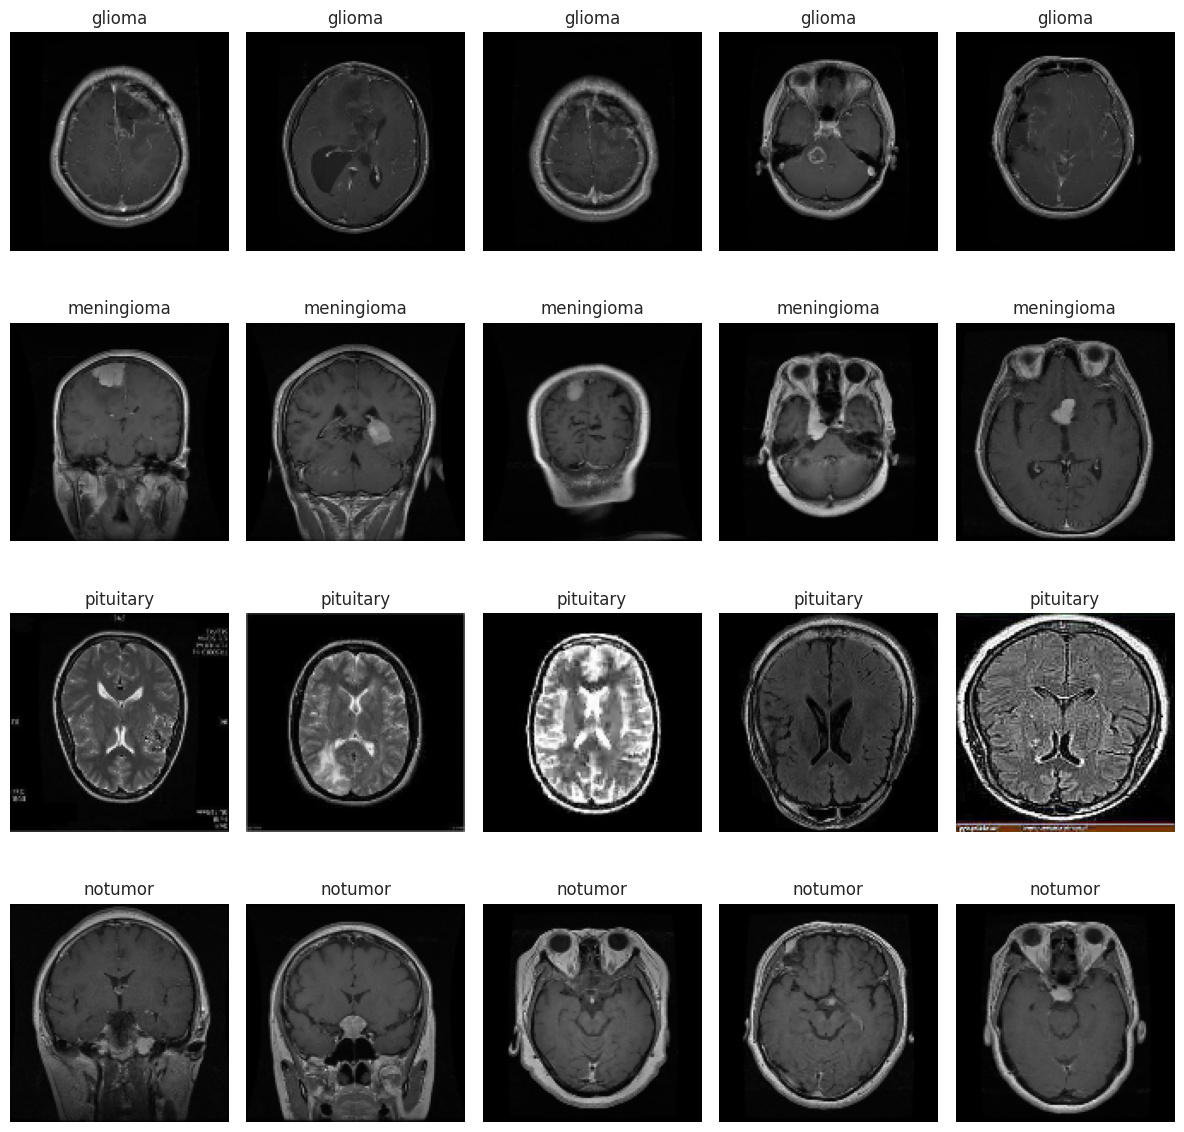

In [ ]:
# 2. Visualize Sample Images from Each Category
import matplotlib.pyplot as plt

# 2. Visualize Sample Images from Each Category
def plot_sample_images(X, y, categories, samples_per_class=5):
    plt.figure(figsize=(12, 12))
    for category_index, category in enumerate(categories):
        category_images = X[y.argmax(axis=1) == category_index]

        # Ensure that there are enough images to sample
        num_images = min(len(category_images), samples_per_class)

        for i in range(num_images):
            plt.subplot(len(categories), samples_per_class, i + 1 + category_index * samples_per_class)
            plt.imshow(category_images[i], cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

categories = ['glioma', 'meningioma', 'pituitary', 'notumor']
plot_sample_images(X_train, y_train, categories)


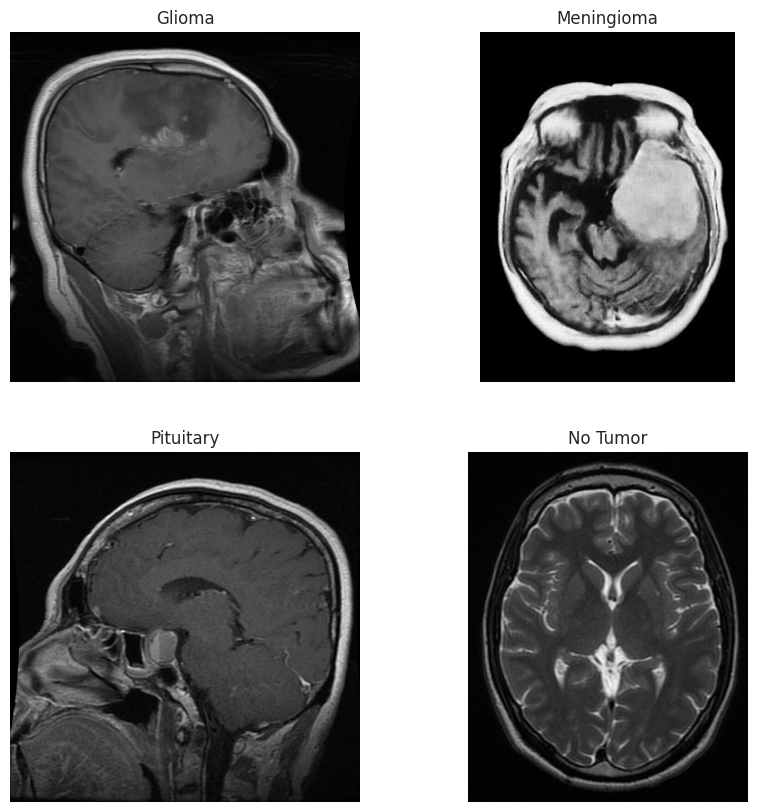

In [ ]:
import matplotlib.image as mpimg
import random

def display_sample_images(class_dir, label, ax):
    # Load a random image from the directory
    image_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
    image = mpimg.imread(image_path)

    # Display image
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# Plot sample images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

display_sample_images(glioma_dir, 'Glioma', axs[0, 0])
display_sample_images(meningioma_dir, 'Meningioma', axs[0, 1])
display_sample_images(pituitary_dir, 'Pituitary', axs[1, 0])
display_sample_images(notumor_dir, 'No Tumor', axs[1, 1])

plt.show()

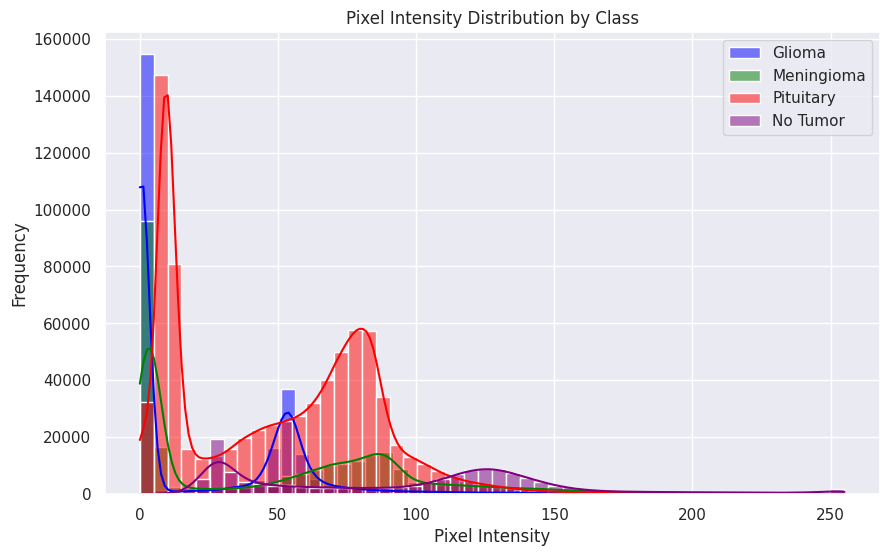

In [ ]:
import numpy as np

def get_random_image_intensity(class_dir):
    image_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
    image = mpimg.imread(image_path)
    return image.flatten()

# Get pixel intensity distributions for each class
glioma_intensity = get_random_image_intensity(glioma_dir)
meningioma_intensity = get_random_image_intensity(meningioma_dir)
pituitary_intensity = get_random_image_intensity(pituitary_dir)
notumor_intensity = get_random_image_intensity(notumor_dir)

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(glioma_intensity, bins=50, color='blue', label='Glioma', kde=True)
sns.histplot(meningioma_intensity, bins=50, color='green', label='Meningioma', kde=True)
sns.histplot(pituitary_intensity, bins=50, color='red', label='Pituitary', kde=True)
sns.histplot(notumor_intensity, bins=50, color='purple', label='No Tumor', kde=True)

plt.title('Pixel Intensity Distribution by Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Unique image dimensions: Counter({(128, 128, 3): 5771})


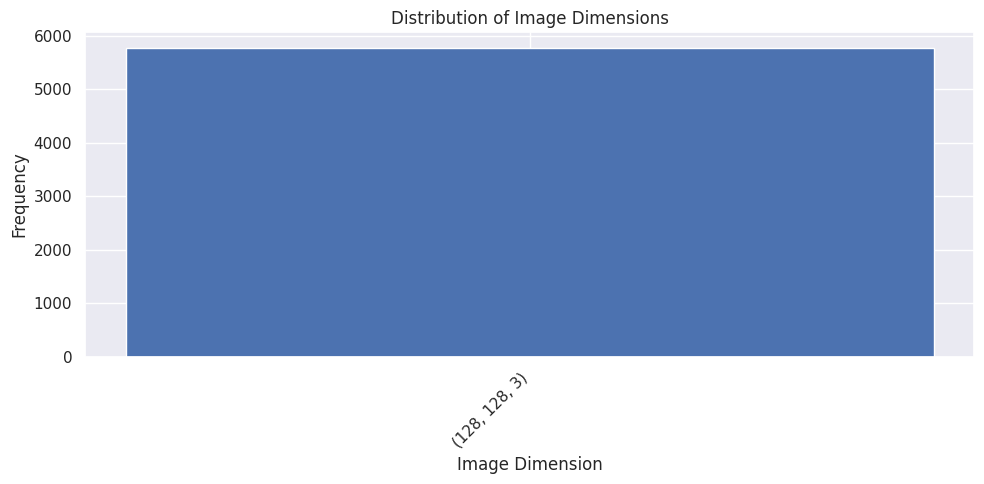

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# 3. Analyze Image Dimensions
def analyze_image_dimensions(X):
    # Extract dimensions of each image
    dimensions = [img.shape for img in X]

    # Count the frequency of each unique dimension
    unique_dims = Counter(dimensions)

    # Display the unique dimensions and their counts
    print(f"Unique image dimensions: {unique_dims}")

    # Plot the distribution of image dimensions
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(unique_dims)), list(unique_dims.values()), align='center')
    plt.xticks(range(len(unique_dims)), [str(dim) for dim in unique_dims.keys()], rotation=45, ha='right')
    plt.title("Distribution of Image Dimensions")
    plt.xlabel("Image Dimension")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Example usage
analyze_image_dimensions(X_train)


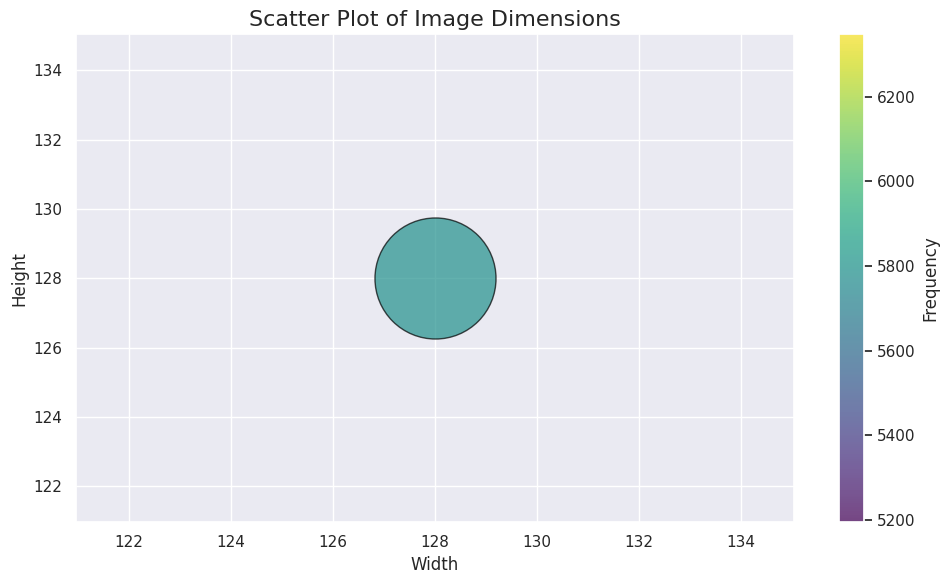

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_image_dimensions_scatter(X):
    # Extract dimensions of each image
    dimensions = [img.shape[:2] for img in X]  # Only height and width, ignoring channels

    # Count the frequency of each unique dimension
    unique_dims = Counter(dimensions)

    # Unpack dimensions and their counts for plotting
    heights, widths, counts = zip(*[(dim[0], dim[1], count) for dim, count in unique_dims.items()])

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(widths, heights, s=np.sqrt(counts) * 100, c=counts, cmap='viridis', alpha=0.7, edgecolor='black')

    # Add a color bar to represent the count of each dimension
    cbar = plt.colorbar(scatter)
    cbar.set_label('Frequency', fontsize=12)

    # Add titles and labels
    plt.title('Scatter Plot of Image Dimensions', fontsize=16)
    plt.xlabel('Width', fontsize=12)
    plt.ylabel('Height', fontsize=12)

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
analyze_image_dimensions_scatter(X_train)

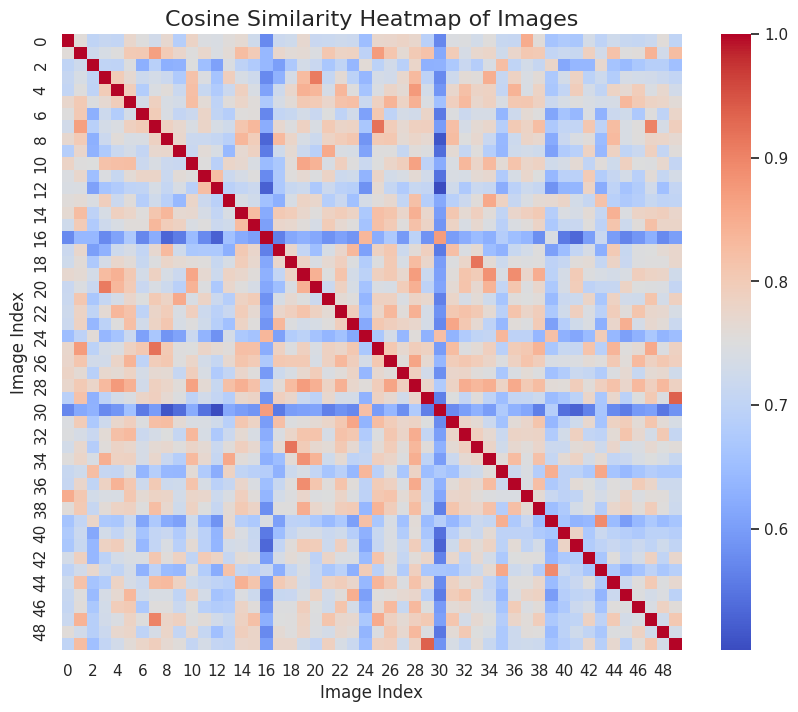

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_heatmap(X):
    # Flatten the images for cosine similarity calculation
    X_flattened = [img.flatten() for img in X]

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(X_flattened)

    # Plot heatmap of cosine similarity
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='coolwarm', cbar=True)
    plt.title('Cosine Similarity Heatmap of Images', fontsize=16)
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.show()

# Example usage with a subset of images
cosine_similarity_heatmap(X_train[:50])

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

Subdirectories in /content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training: ['pituitary', 'notumor', 'glioma', 'meningioma']
Files in /content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary: ['/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0473.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0563.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0548.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0594.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0510.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0508.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0618.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-p

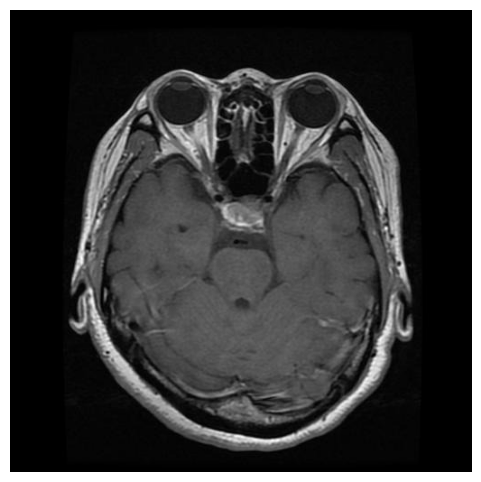

In [ ]:
def load_dicom_line(path, max_images=5):
    # List all subdirectories and files in the root directory
    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    print(f"Subdirectories in {path}: {subdirs}")

    # Iterate through subdirectories and list files
    all_files = []
    for subdir in subdirs:
        subdir_path = os.path.join(path, subdir)
        files = glob.glob(os.path.join(subdir_path, "*"))
        print(f"Files in {subdir_path}: {files}")
        all_files.extend(files)

    # Sort and limit the files
    t_paths = sorted(
        [f for f in all_files if os.path.isfile(f)],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x))) or 0),
    )

    print(f"Total files detected: {t_paths}")

    images = []
    for i, filename in enumerate(t_paths):
        if i >= max_images:
            break
        try:
            # Load image
            data = Image.open(filename).convert('L')  # Convert to grayscale
            data = np.array(data)
            if data.max() == 0:
                print(f"Skipping empty image: {filename}")
                continue
            images.append(data)
            print(f"Loaded image: {filename}")
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue

    if not images:
        print("No valid images found in the specified directory.")
    return images

# Set the path to your dataset directory
train_dir = '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training'  # Replace with your actual dataset directory path

# Load only 5 images
images = load_dicom_line(train_dir, max_images=5)

# Create and display the animation if images are loaded
if images:
    anim = create_animation(images)
    if anim:
        anim


Subdirectories in /content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training: ['pituitary', 'notumor', 'glioma', 'meningioma']
Files in /content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary: ['/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0473.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0563.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0548.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0594.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0510.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0508.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-pi_0618.jpg', '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training/pituitary/Tr-p

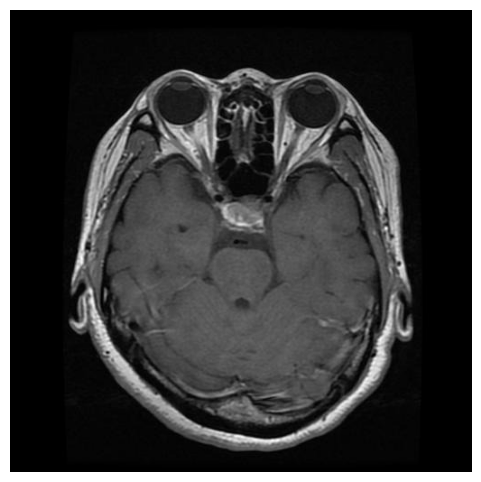

In [ ]:
images = load_dicom_line('/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Training')
create_animation(images)

 Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]  # (128, 128, 3)
num_classes = y_train.shape[1]   # 4 classes

# Build and compile the model
model = build_cnn_model(input_shape, num_classes)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.5987 - loss: 2.5179 - val_accuracy: 0.0000e+00 - val_loss: 38.4194
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7465 - loss: 0.6897 - val_accuracy: 0.0000e+00 - val_loss: 12.1209
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7622 - loss: 0.5855 - val_accuracy: 0.1463 - val_loss: 6.4239
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7986 - loss: 0.4965 - val_accuracy: 0.4892 - val_loss: 2.1816
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8175 - loss: 0.4879 - val_accuracy: 0.6797 - val_loss: 1.7029
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8452 - loss: 0.4005 - val_accuracy: 0.8026 - val_loss: 1.0666
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8030 - loss: 0.5349 - val_accuracy: 0.6900 - val_loss: 2.1009
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8588 - loss: 0.3423

 Model Performance

Test accuracy: 0.9304
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.91      0.93       300
  meningioma       0.82      0.96      0.88       306
   pituitary       0.99      0.89      0.94       405
     notumor       0.97      0.98      0.98       310

    accuracy                           0.93      1321
   macro avg       0.93      0.93      0.93      1321
weighted avg       0.94      0.93      0.93      1321



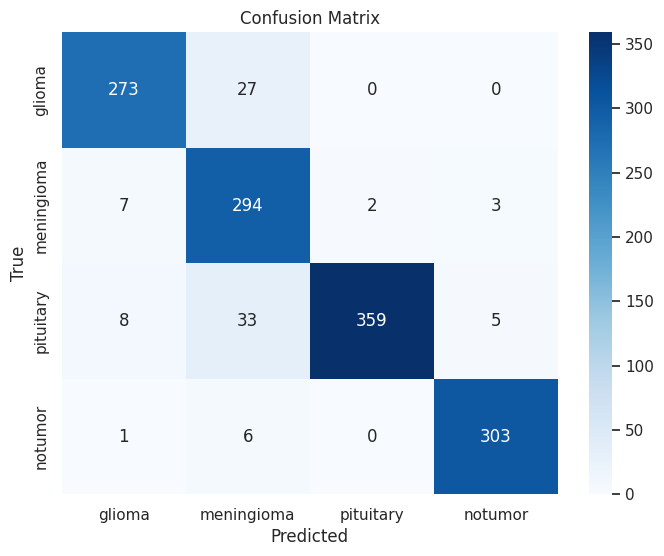

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Ploting model evaluation


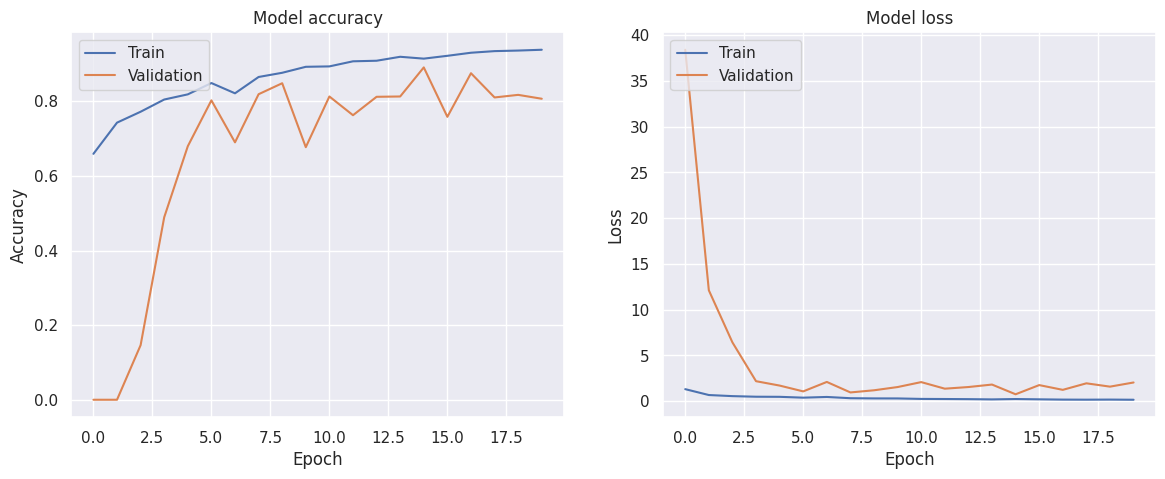

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Correlation matrix

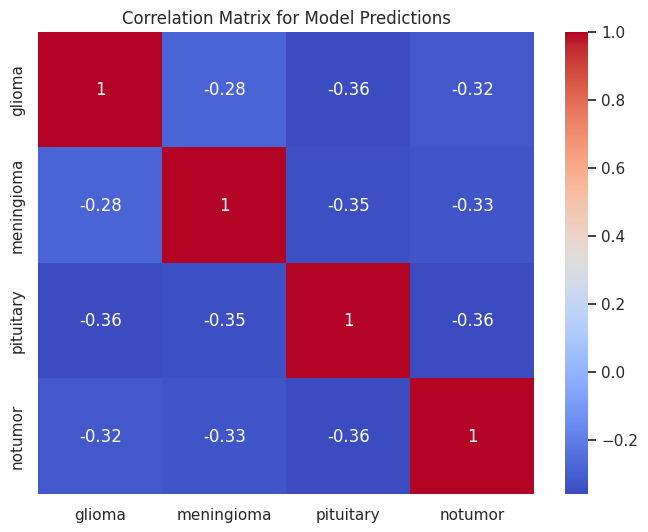

In [ ]:
# Heatmap for correlation matrix
correlation_matrix = np.corrcoef(y_pred.T)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=categories, yticklabels=categories)
plt.title('Correlation Matrix for Model Predictions')
plt.show()


Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


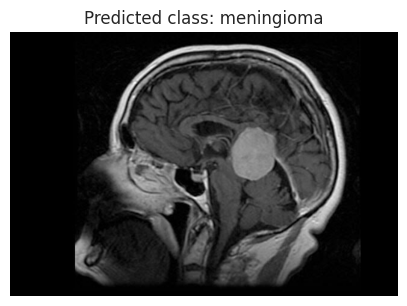

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_model_on_image(model, img_path, img_size=(128, 128)):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized / 255.0
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Predict the class using the model
    prediction = model.predict(img_expanded)
    predicted_class = categories[np.argmax(prediction)]

    # Display the image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Define your categories
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Example usage
test_model_on_image(model, '/content/drive/MyDrive/Colab Notebooks/NN_project/NN_project/Testing/meningioma/Te-me_0058.jpg')


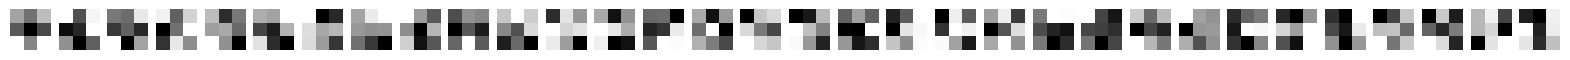

In [ ]:
import matplotlib.pyplot as plt

# Get filters and biases from the first convolutional layer
filters, biases = model.layers[0].get_weights()  # First convolutional layer
# Normalize the filters for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot all filters
n_filters = filters.shape[-1]
fig, axs = plt.subplots(1, n_filters, figsize=(20, 20))
for i in range(n_filters):
    f = filters[:, :, :, i]
    axs[i].imshow(f[:, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

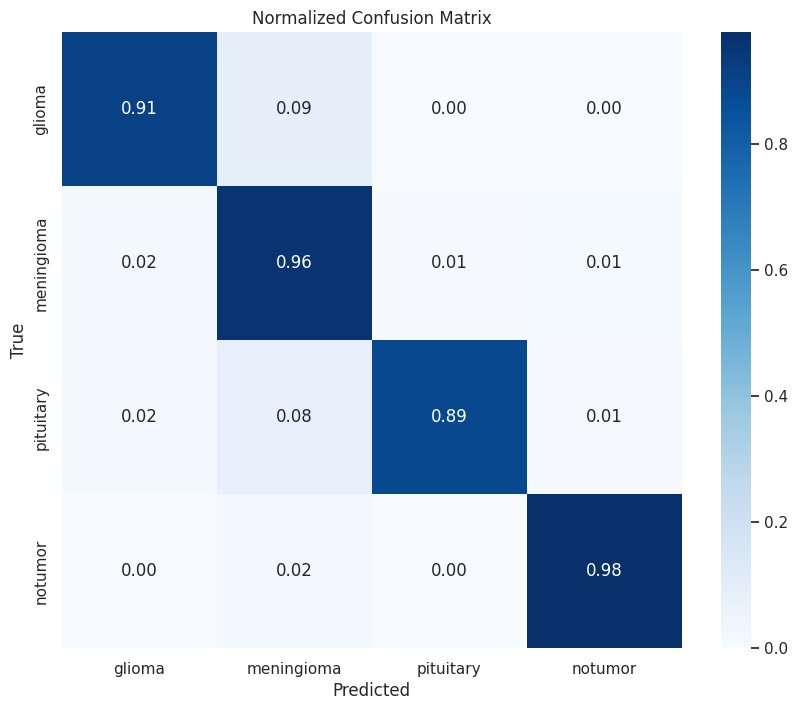

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, categories):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_normalized_confusion_matrix(y_true, y_pred_classes, categories)

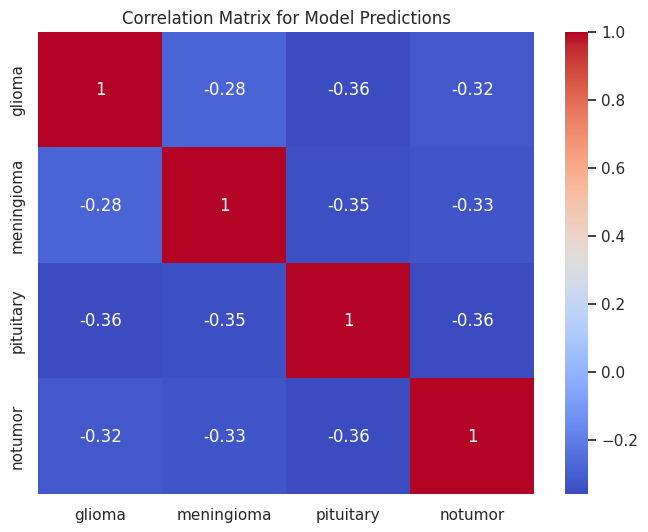

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = np.corrcoef(y_pred.T)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=categories, yticklabels=categories)
plt.title('Correlation Matrix for Model Predictions')
plt.show()

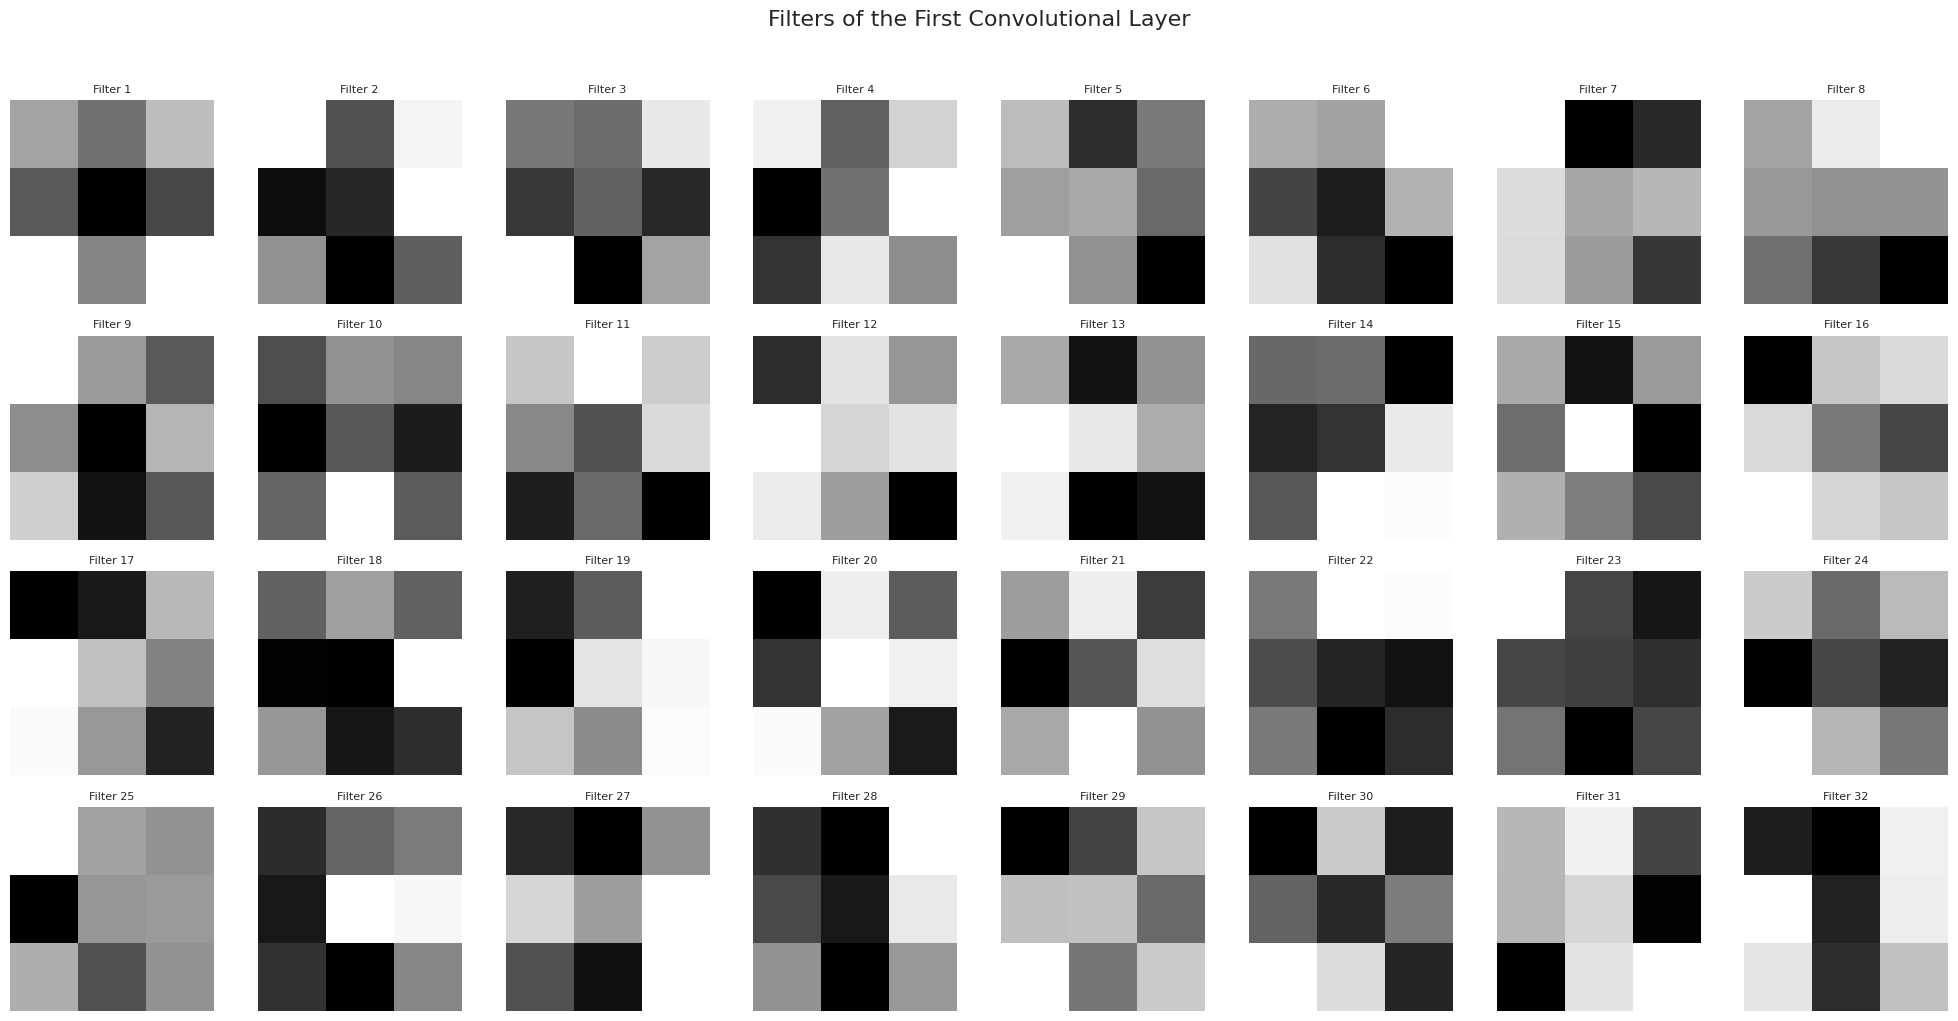

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get filters and biases from the first convolutional layer
filters, biases = model.layers[0].get_weights()  # First convolutional layer

# Normalize the filters for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Number of filters
n_filters = filters.shape[-1]

# Calculate grid size
n_cols = 8  # Number of columns
n_rows = int(np.ceil(n_filters / n_cols))  # Number of rows needed

# Create figure and axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
fig.suptitle('Filters of the First Convolutional Layer', fontsize=16, y=1.02)  # Title for the entire figure

# Plot all filters
for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    if i < n_filters:
        f = filters[:, :, :, i]
        ax.imshow(f[:, :, 0], cmap='gray')
        ax.set_title(f'Filter {i + 1}', fontsize=8)  # Title for each filter
    ax.axis('off')  # Hide axis for all subplots

plt.tight_layout()
plt.show()